In [1]:
from Utils.FS import file
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from scipy.sparse import coo_matrix, dok_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
np.random.seed(1234)

In [3]:
sents = brown.sents()
sents = [[token.lower() for token in sent] for sent in sents]
words = brown.words()
words = [word.lower() for word in words]

In [4]:
print("Number of tokens: {}".format(len(words)))
print("Number of sentences: {}".format(len(sents)))
print("Longest sentences length: {}".format(max([len(sent) for sent in sents])))

Number of tokens: 1161192
Number of sentences: 57340
Longest sentences length: 180


In [5]:
def words2dicts(words):
    f_dict = {}
    index = 0
    for word in words:
        if not word in f_dict.keys():
            f_dict[word] = index
            index = index + 1
        
    return f_dict, { v:k for k, v in f_dict.items()}

In [6]:
words_dict, inv_words_dict = words2dicts(words)
words_size = len(words_dict)
print("Number of unique tokens: {}".format(words_size))

Number of unique tokens: 49815


In [7]:
def singleSideWindow(sents, words_dict, window_size, reverse = False):
    window = []
    row = []
    col = []
    data = []
        
    for sent in reversed(sents) if reverse else sents:
        for word in reversed(sent) if reverse else sent:
            for w in window:
                if w == word:
                    continue
                row.append(words_dict[word])
                col.append(words_dict[w])
                data.append(1)
            if len(window) == window_size:
                window.pop(0)
            window.append(word)
    return coo_matrix((data, (row, col)), shape=(len(words_dict), len(words_dict)), dtype='float64')
    

def sents2wordContextMatrix(sents, words_dict, window_size = 5):
    m = coo_matrix((words_size, words_size), 'float64')
    
    print('Doing forward pass...')
    m += singleSideWindow(sents, words_dict, window_size)
    
    print('Doing backward pass...')
    m += singleSideWindow(sents, words_dict, window_size, True)
    
    return m

def sents2wordCoocurrenceMatrix(sents, words_dict, window_size = 10):
    #don't really care edge cases....

    window = []
    row = []
    col = []
    data = []
    for sent in sents:
        for word in sent:
            for i in range(len(window)- 1):
                for j in range(i+1, len(window)):
                    row += [words_dict[window[i]], words_dict[window[j]]]
                    col += [words_dict[window[j]], words_dict[window[i]]]
                    data += [1, 1]
            if len(window) == window_size:
                window.pop(0)
            window.append(word)
    print('Preparing sparse matrix...')
    print('Length of data: {}'.format(len(data)))
    return coo_matrix((data, (row,col)), shape=(words_size, words_size), dtype='float64').multiply(1/len(data))

In [8]:
def sents2freq(sents):
    freq = {}
    for sent in sents:
        for word in sent:
            if word in freq.keys():
                freq[word] += 1
            else:
                freq[word] = 1
    return freq

words_freq = sents2freq(sents)

In [9]:
WINDOW_SIZE = 5
m = sents2wordContextMatrix(sents, words_dict, WINDOW_SIZE)

Doing forward pass...
Doing backward pass...


In [10]:
#y = m.dot(m.T)
y = m

In [11]:
SVD_DIMENSION=50
u, s, vt = svds(y, k=SVD_DIMENSION)

In [12]:
words_mat = np.matmul(u, np.diag(s))

In [13]:
words_vec = {}
for i in range(words_mat.shape[0]):
    words_vec[inv_words_dict[i]] = words_mat[i]

In [14]:
def plotData(vocabs, X, Y):
    plt.clf()
    plt.figure(figsize=(36, 36))
    plt.scatter(X, Y)
    plt.axis([min(X), max(X), min(Y), max(Y)])
    for label, x, y in zip(vocabs, X, Y):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()    

In [15]:
def plot(vocabs, words_vec):
    X = [words_vec[vocab][0] for vocab in vocabs]
    Y = [words_vec[vocab][1] for vocab in vocabs]
    plotData(vocabs, X, Y)

In [16]:
def plotTSNE(vocabs, vectors):
    tsne = TSNE(perplexity=30, n_components=2, n_iter=5000, random_state = 7890)
    #np.set_printoptions(suppress=True)
    data = np.array([vectors[vocab] for vocab in vocabs])    
    DATA = tsne.fit_transform(data)
    X = DATA[:, 0]
    Y = DATA[:, 1]
    
    plotData(vocabs, X, Y)

In [17]:
from DataLoader import GloVe

glove = GloVe.load2('./data/GloVe/glove.6B.50d.txt')

Start: Loading Glove Model
End: Loaded 400000 rows.


In [18]:
vocabs = ['man', 'woman', 'king', 'queen', 'male', 'female', 'boy', 'girl']
np.random.seed(1234)

random_vocabs = []
for i in np.random.randint(0, len(words_dict), 2000):
    if inv_words_dict[i] in glove.keys():
        random_vocabs.append(inv_words_dict[i])
        
print(len(random_vocabs))

1616


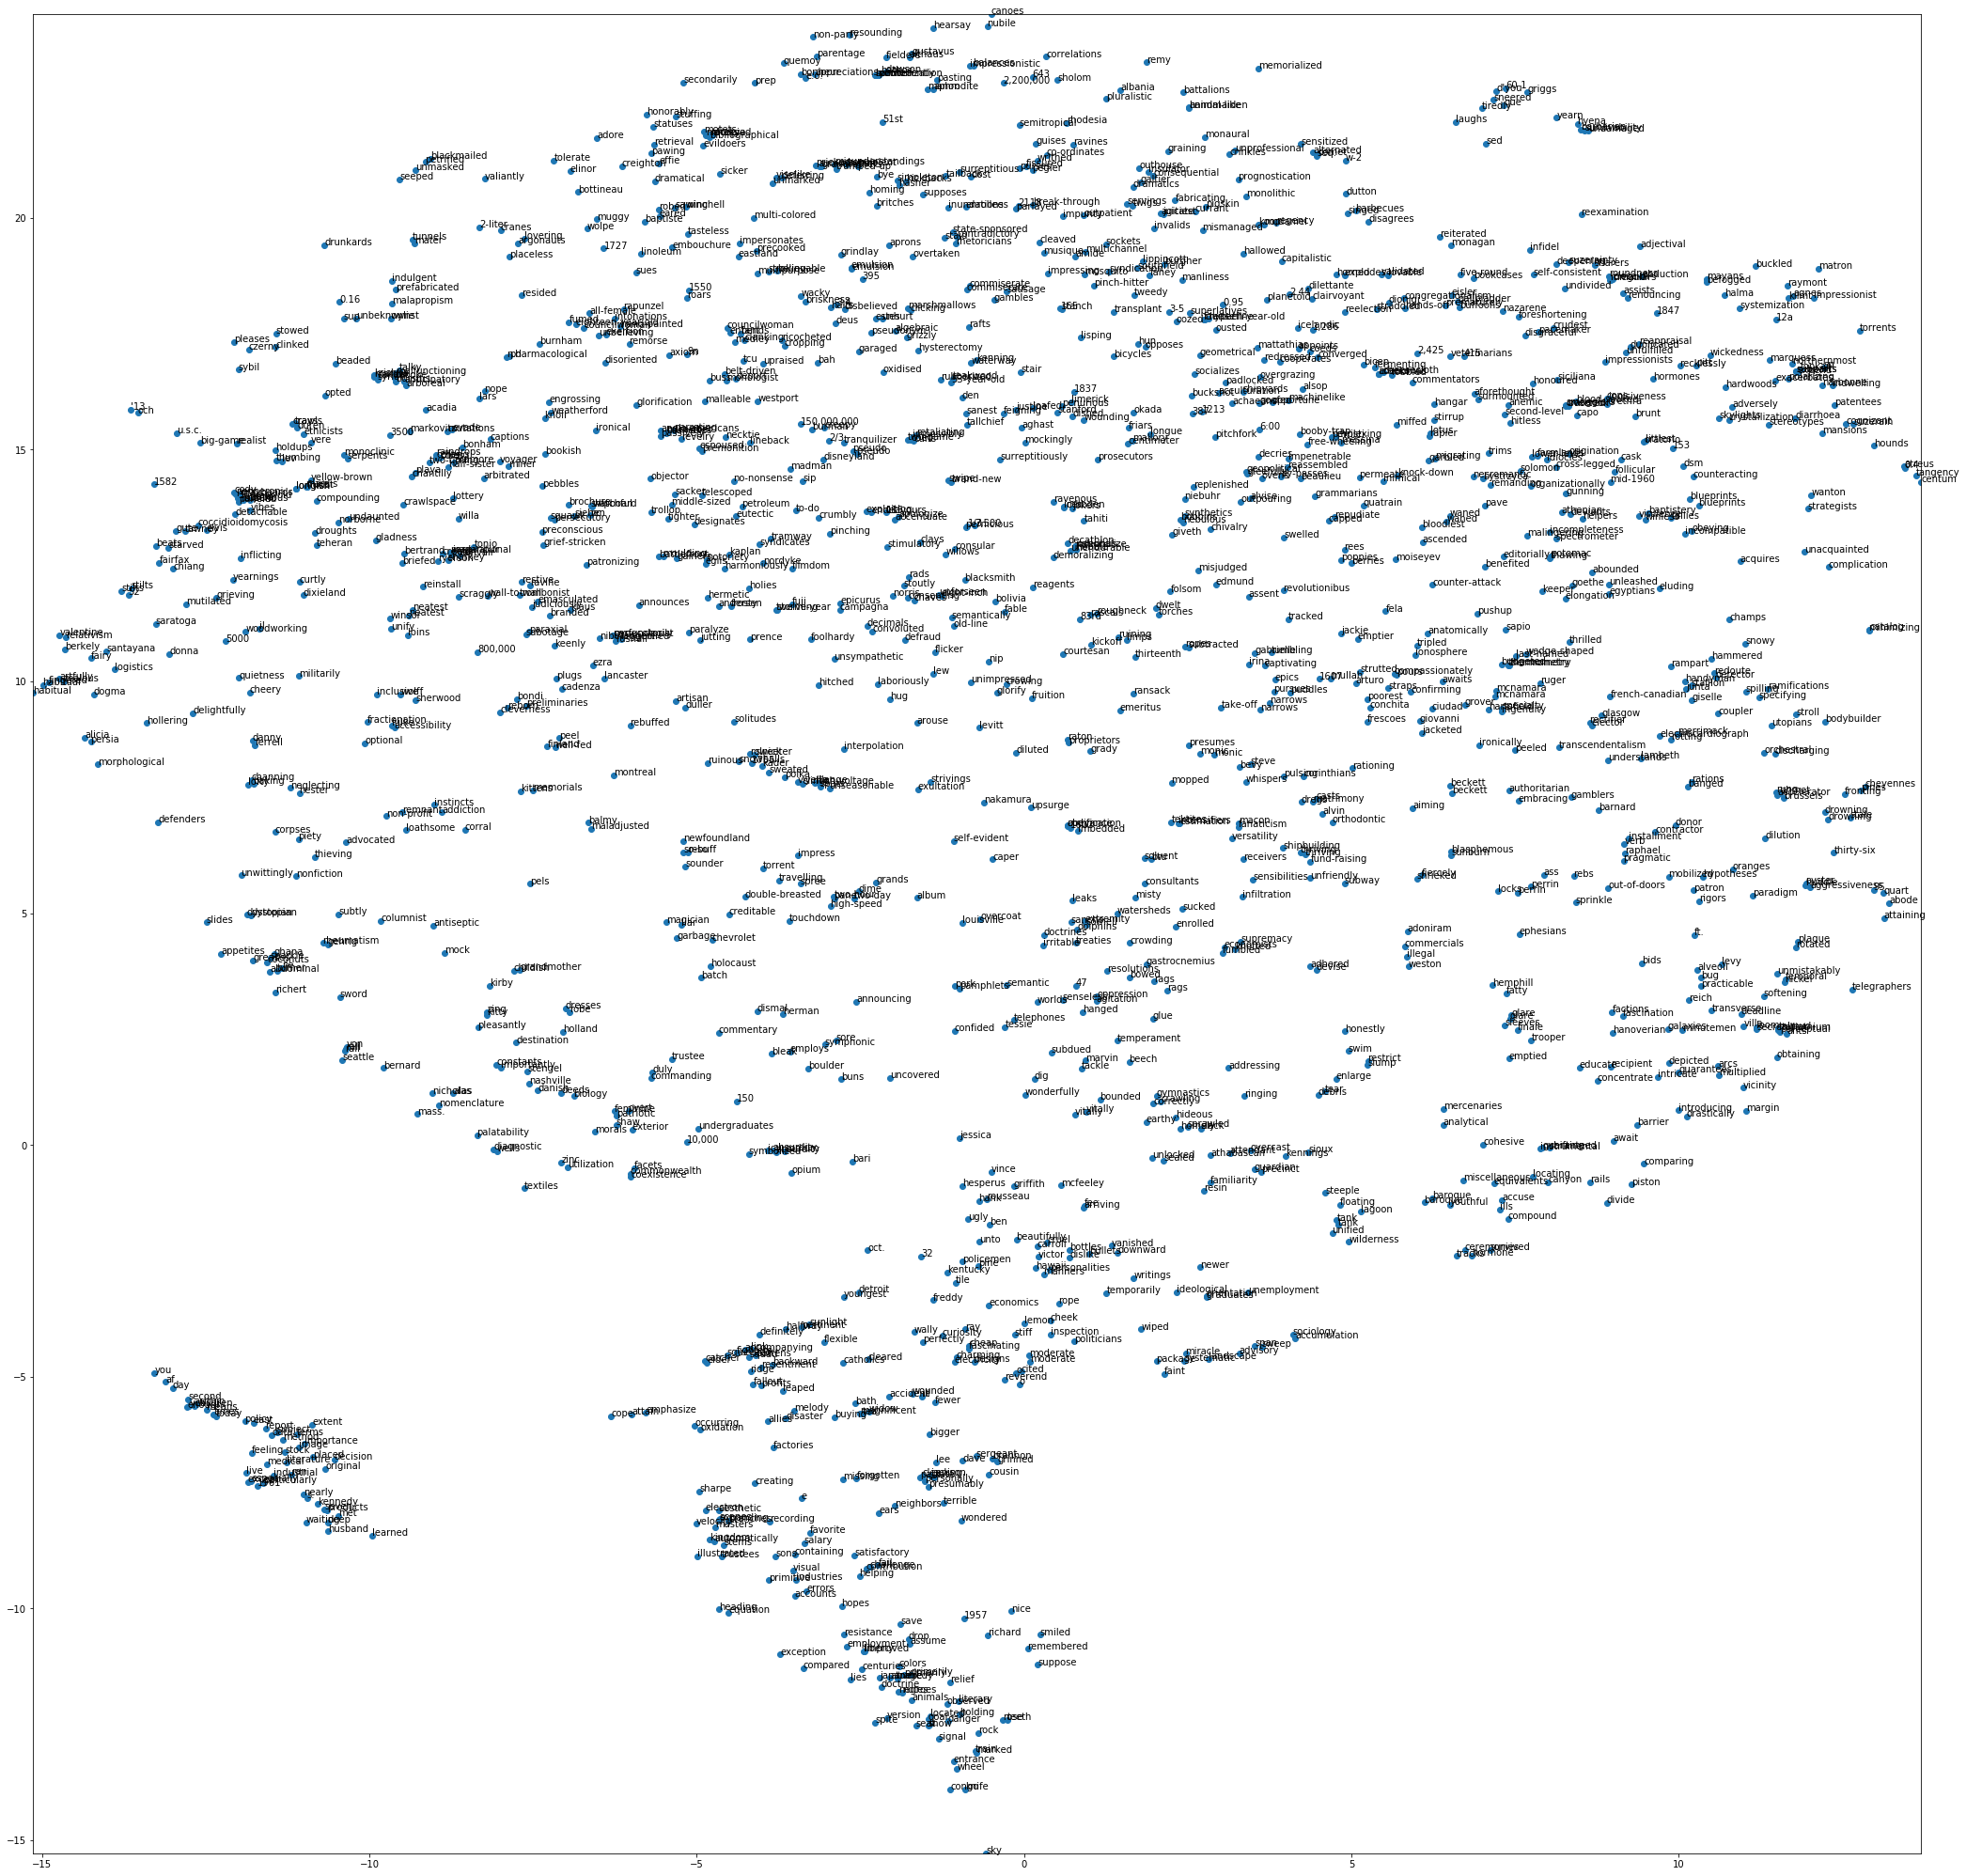

In [19]:
plotTSNE(random_vocabs, words_vec)

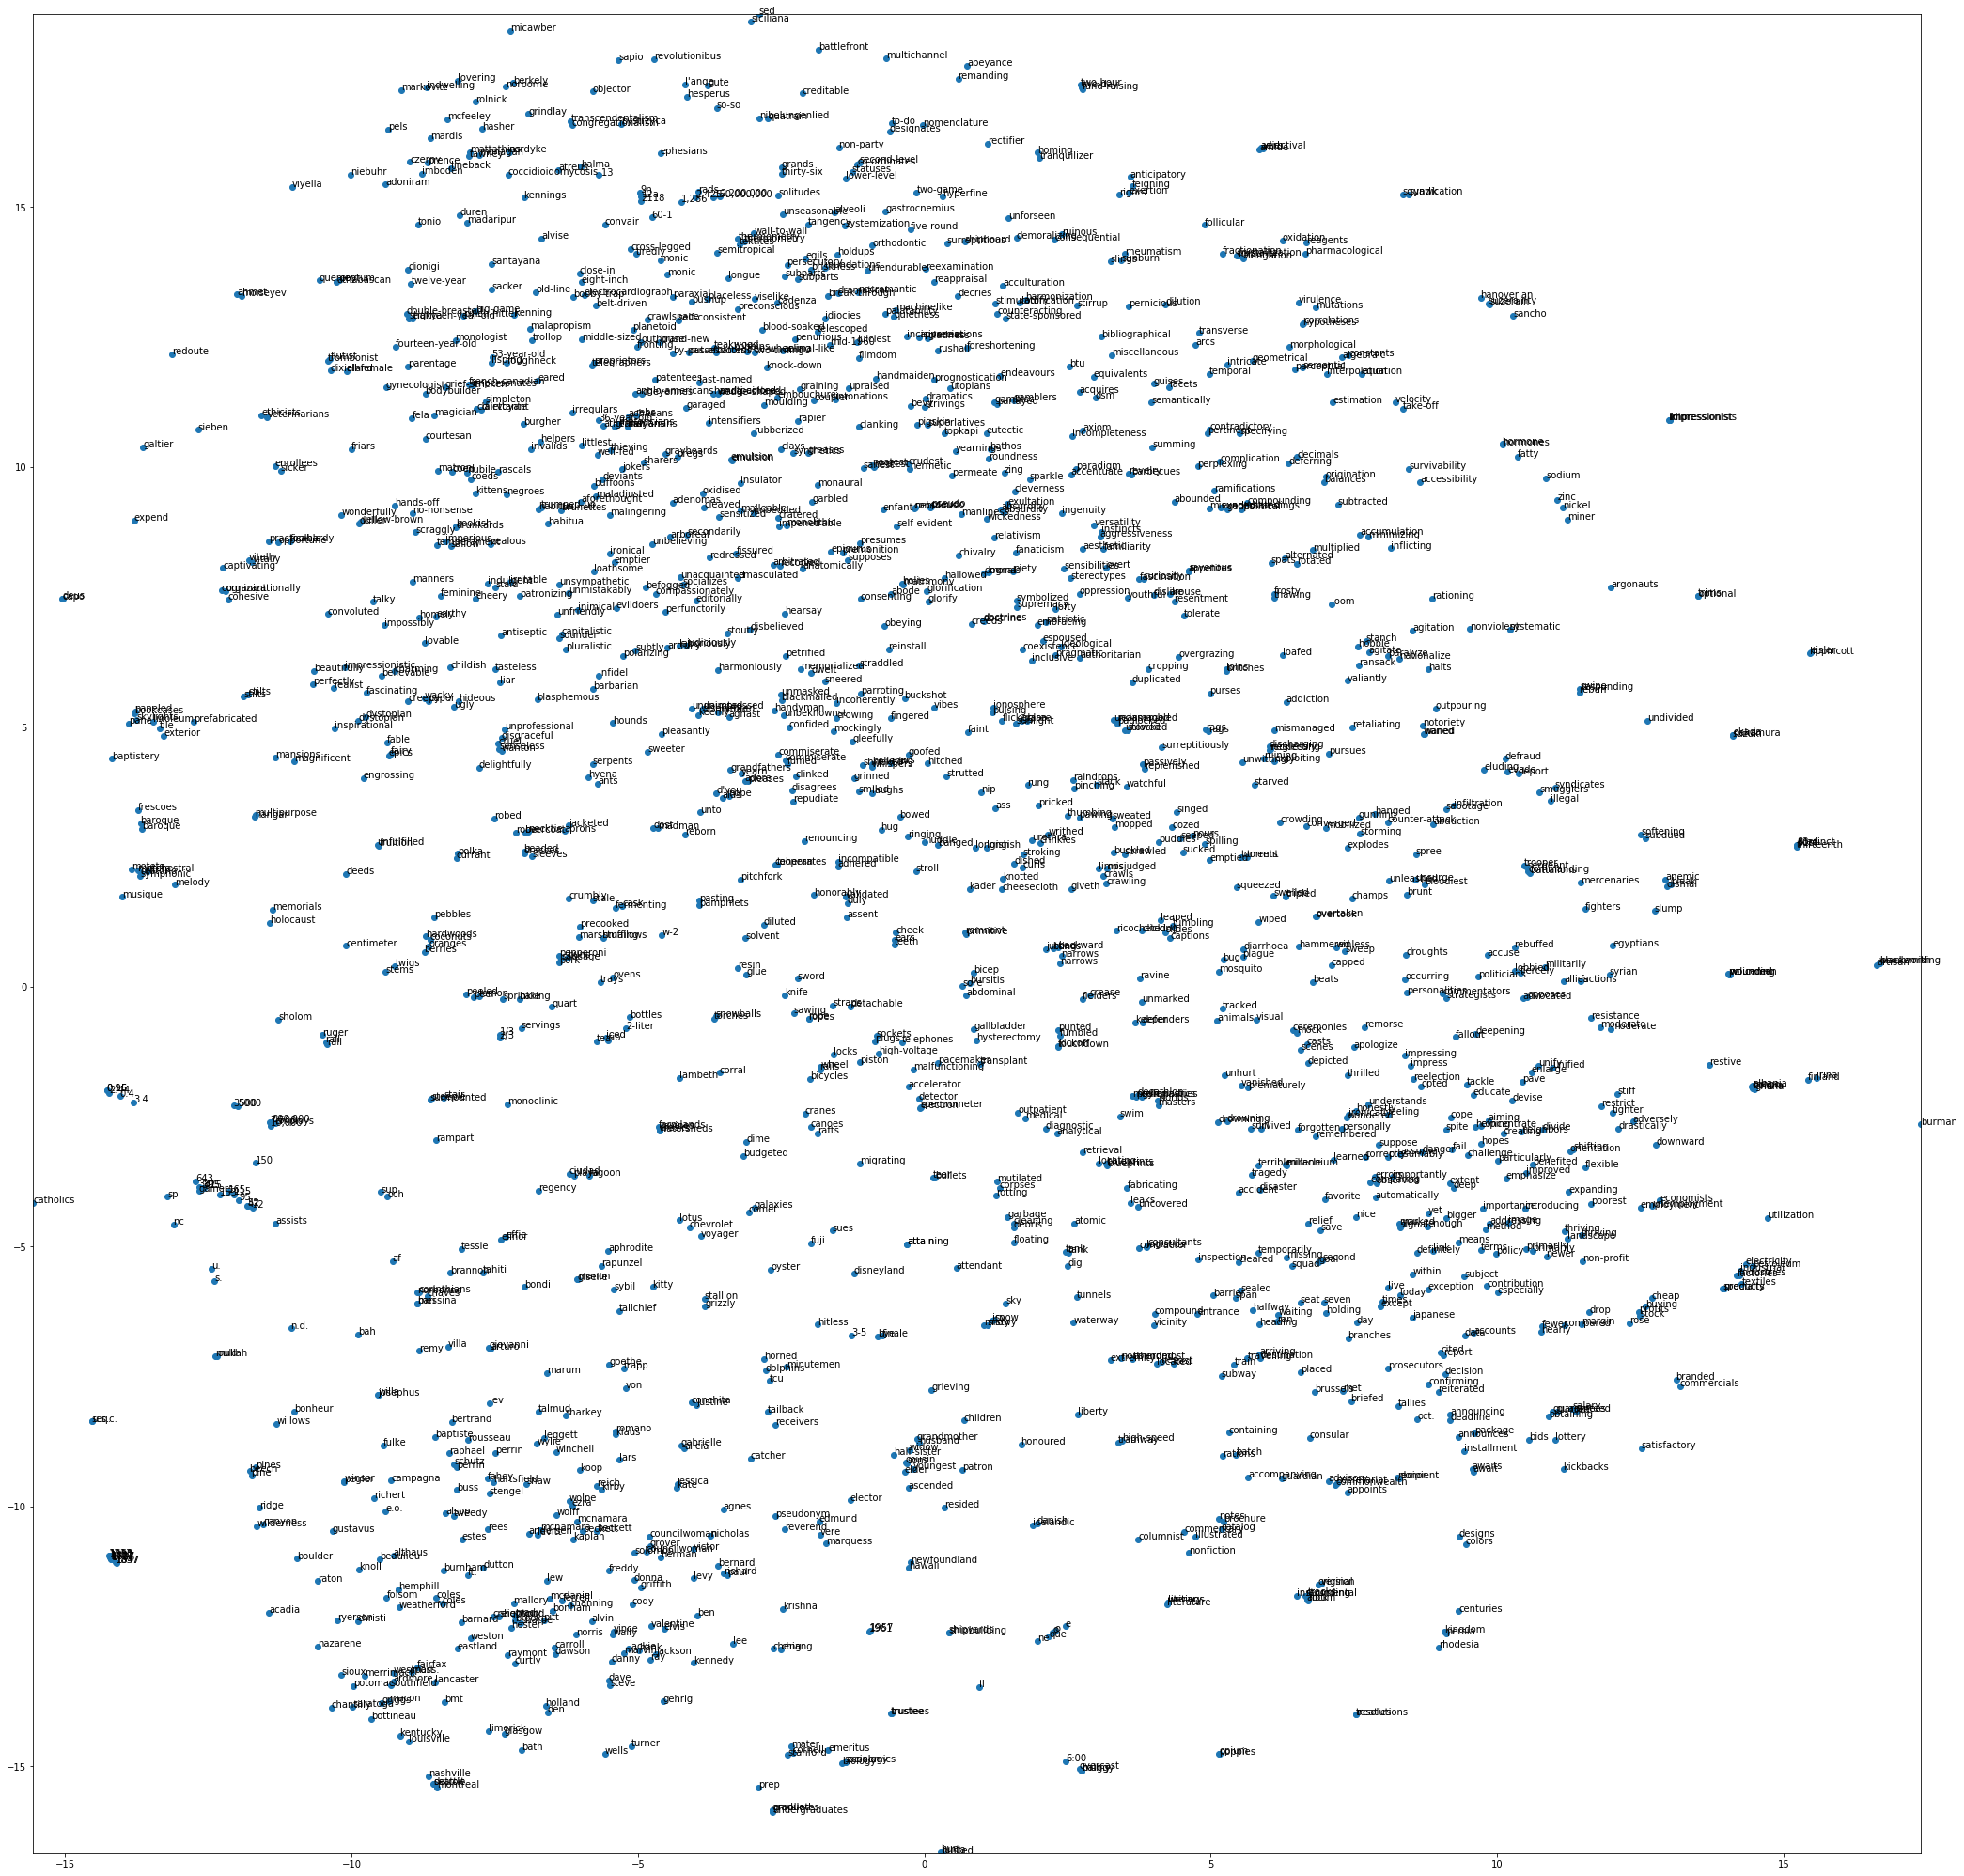

In [20]:
plotTSNE(random_vocabs, glove)

In [25]:
def cloestWord(word, words_vec, count = 10):
    dist = np.array([ sum(np.square(np.array(words_vec[word]) - np.array(words_vec[key]))) for key in words_vec.keys()])
    return [list(words_vec.keys())[i] for i in dist.argsort()[:10]]

In [26]:
print(cloestWord('man', words_vec))
print(cloestWord('man', glove))

['man', 'like', 'after', 'over', 'even', 'made', 'also', 'now', 'such', 'about']
['man', 'woman', 'another', 'boy', 'one', 'old', 'turned', 'whose', 'himself', 'who']


In [27]:
print(cloestWord('woman', words_vec))
print(cloestWord('woman', glove))

['woman', 'girl', 'child', 'boy', 'job', 'short', 'real', 'special', 'strong', 'red']
['woman', 'girl', 'man', 'mother', 'boy', 'her', 'she', 'herself', 'victim', 'child']


In [28]:
print(cloestWord('however', words_vec))
print(cloestWord('however', glove))

['however', 'too', 'mr.', 'still', 'course', 'mrs.', 'very', 'while', 'being', 'where']
['however', 'although', 'though', 'as', 'both', 'latter', 'also', '.', 'same', 'fact']


In [29]:
print(cloestWord('his', words_vec))
print(cloestWord('his', glove))

['his', 'as', 'with', 'this', 'had', 'at', 'i', 'but', 'be', 'not']
['his', 'he', 'himself', 'him', 'took', 'came', 'her', 'when', 'having', 'she']


In [22]:
print(cloestWord('zero', words_vec))
print(cloestWord('zero', glove))

['zero', 'accelerometer', 'input', 'gyro', 'register', 'transom', 'sink', 'nearest', 'memorial', 'measuring']
['zero', 'mean', 'assuming', 'hence', 'actual', 'approaching', 'comparable', 'measured', 'limit', 'comparison']


In [23]:
print(cloestWord('one', words_vec))
print(cloestWord('one', glove))

['one', 'an', 'all', '--', 'were', 'or', 'which', 'their', 'they', 'out']
['one', 'another', 'only', 'same', '.', 'as', 'well', 'but', 'with', 'making']


In [24]:
print(cloestWord('two', words_vec))
print(cloestWord('two', glove))

['two', 'most', 'over', 'first', 'new', 'after', 'some', 'af', 'other', 'even']
['two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'with', 'several']
